# Introduction

This notebook performs the data normalisation of the collection of pancreas data. This collection consists of the following data sets:

* CelSeq (GSE81076)
* CelSeq2 (GSE85241)
* Fluidigm C1 (GSE86469)
* SMART-Seq2 (E-MTAB-5061)
* inDrop (GSE84133)
* SMARTer (GSE81608)

For all but the SMARTer dataset, we perform *scran* normalisation. Subsequently, we log-scale all data sets.

Import packages.

In [1]:
import sys
# I have to add paths to the following github repos
sys.path.append('~/Python/scanpy/')
sys.path.append('~/Python/anndata/')
sys.path.append('~/Python/anndata2ri/')

In [2]:
import anndata
import scanpy as sc
import scipy as sci
sc.logging.print_versions()

scanpy==1.4.5.dev65+g67d51e4 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.0 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
sc.settings.verbosity = 3

In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [5]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [6]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Load data

In the following, import the `csv` files (created in R) to convert them into an `anndata` file.

In [7]:
path_dir = '../data/'

In [14]:
adata = sc.read_csv(filename = path_dir + 'human_pancreas.csv').T

In [15]:
metadata = pd.read_csv(path_dir + 'human_pancreas_meta.csv', index_col=0)

In [16]:
metadata

,tech,celltype
D101_5,celseq,gamma
D101_43,celseq,gamma
D101_93,celseq,gamma
D102_4,celseq,gamma
D172444_23,celseq,gamma
D172444_68,celseq,gamma
D17All1_2,celseq,gamma
D17All1_18,celseq,gamma
D17All1_28,celseq,gamma
D17All1_72,celseq,gamma


In [17]:
adata.obs['tech'] = metadata['tech'].values
adata.obs['celltype'] = metadata['celltype'].values

Save to file.

In [18]:
sc.write(adata=adata, filename = path_dir + 'human_pancreas.h5ad')

... storing 'tech' as categorical
... storing 'celltype' as categorical


In [8]:
adata = sc.read(path_dir + 'human_pancreas.h5ad')

# Normalize with scran per data set

Here, we split the data by dataset (i.e. tech variable). All but the 'smarter' dataset (which is in RPKM) will be normalised with scran. 

In [9]:
%%R

# Load all the R libraries we will be using in the notebook
library(scran)
#library(RColorBrewer)
#library(slingshot)
#library(monocle)
#library(gam)
#library(clusterExperiment)
#library(ggplot2)
#library(plyr)
#library(MAST)

Perform clustering.

In [60]:
a,b = np.unique(adata.obs['tech'], return_index=True)

In [84]:
protocol_id = a[np.argsort(b)]

In [71]:
adatas =[]
for protocol in enumerate(a[np.argsort(b)]):
    print(protocol[1])
    adata_pp = adata[adata.obs['tech']==protocol[1]].copy()
    if protocol[1]!='smarter':
        sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
        sc.pp.log1p(adata_pp)
        sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
        sc.pp.neighbors(adata_pp)
        sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)
        #Preprocess variables for scran normalization
    adatas.append(adata_pp)


celseq
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)
celseq2
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', wei

/home/icb/maren.buettner/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../home/icb/maren.buettner/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:01)
smarter


We have to assign the clusters manually in order to call the size factor computation in R.

In [85]:
#Preprocess variables for scran normalization
input_groups = adatas[0].obs['groups']
data_mat = adata[adata.obs['tech']==protocol_id[0]].X.T

In [86]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

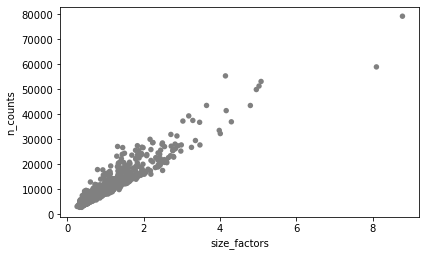

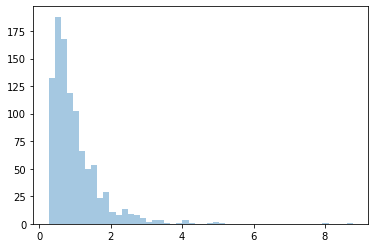

In [87]:
# Visualize the estimated size factors
adatas[0].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[0], 'size_factors', 'n_counts')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [88]:
#Preprocess variables for scran normalization
input_groups = adatas[1].obs['groups']
data_mat = adata[adata.obs['tech']==protocol_id[1]].X.T

In [89]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

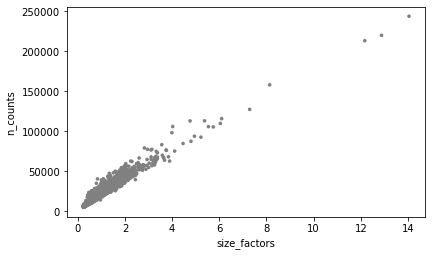

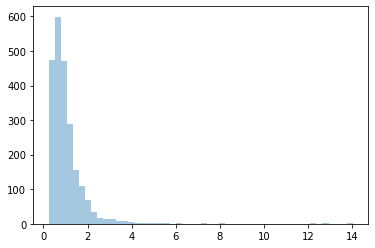

In [90]:
# Visualize the estimated size factors
adatas[1].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[1], 'size_factors', 'n_counts')


sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [91]:
#Preprocess variables for scran normalization
input_groups = adatas[2].obs['groups']
data_mat = adata[adata.obs['tech']==protocol_id[2]].X.T

In [92]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

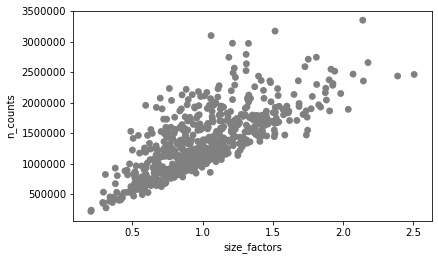

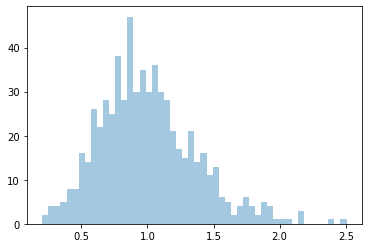

In [93]:
# Visualize the estimated size factors
adatas[2].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[2], 'size_factors', 'n_counts')


sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [94]:
#Preprocess variables for scran normalization
input_groups = adatas[3].obs['groups']
data_mat = adata[adata.obs['tech']==protocol_id[3]].X.T

In [95]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

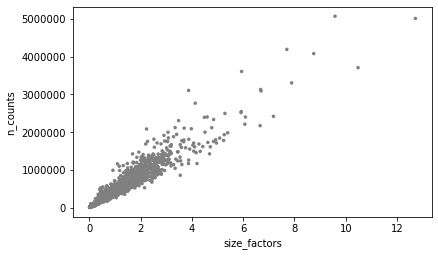

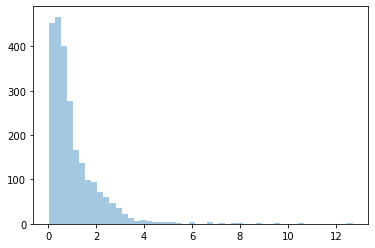

In [96]:
# Visualize the estimated size factors
adatas[3].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[3], 'size_factors', 'n_counts')


sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [97]:
#Preprocess variables for scran normalization
input_groups = adatas[4].obs['groups']
data_mat = adata[adata.obs['tech']==protocol_id[4]].X.T

In [98]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

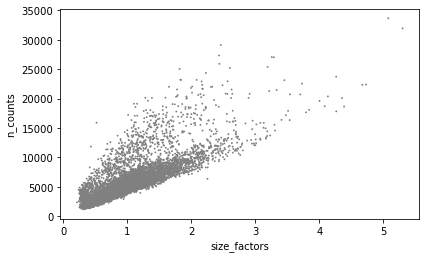

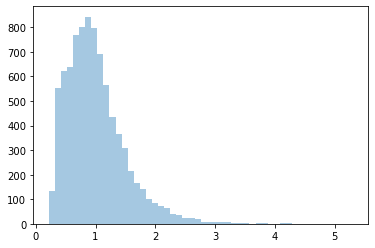

In [99]:
# Visualize the estimated size factors
adatas[4].obs['size_factors'] = size_factors

sc.pl.scatter(adatas[4], 'size_factors', 'n_counts')


sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [100]:
# Set size factor to 1 for RPKM values
adatas[5].obs['size_factors'] = 1

Now, let us concatenate all temporary anndata objects to one file in order to concatenate the size factors to one vector.

In [101]:
adata_tmp = adatas[0].concatenate(adatas[1:])

Assign size factors to original data set collection.

In [105]:
adata.obs['size_factors'] = adata_tmp.obs['size_factors'].values

Check size factor distribution.

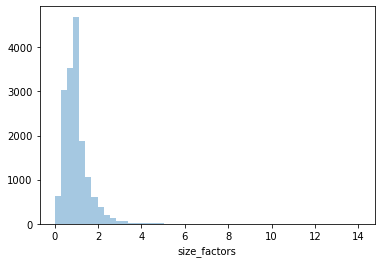

In [106]:
sb.distplot(adata.obs['size_factors'], bins=50, kde=False)
plt.show()

Free memory.

In [111]:
del adata_tmp
del adata_pp
del adatas

Finally, normalise data.

In [112]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

Save normalised data to file.

In [113]:
sc.write(adata=adata, filename=path_dir + 'human_pancreas_norm.h5ad')